## Word2Vec

https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac


In [10]:
import tensorflow as tf

### Read data

In [11]:
import pandas as pd
import numpy as np

In [12]:
# grab words I picked to represent emotions
from emotions import all_flag_words

In [13]:
df = pd.read_csv('../data/processed_comments_1.csv', nrows = 1000)[['words']]

In [14]:
# we only care about comments with flag words
df = df[df['words'].str.contains(r'|'.join(all_flag_words))]

In [15]:
# calculate number of occurences for each word present in dataset
words_dict_counter = {}
step = 10

for comment in df['words']:
    listed_comment = eval(comment)
    contains_word_flag = False

    for i, word in enumerate(listed_comment):

        if word not in words_dict_counter.keys():
            words_dict_counter[word] = {}

        if i-step < 0:
            first_index = 0
            to_delete = i
        else:
            first_index = i-step
            to_delete = step

        corresponding_words = listed_comment[first_index: i+step+1]
        del corresponding_words[to_delete]

        for corresponding_word in corresponding_words:
            if corresponding_word not in words_dict_counter[word].keys():
                words_dict_counter[word][corresponding_word] = 1
            else:
                words_dict_counter[word][corresponding_word] += 1

### Data (pairs) preparation

In [16]:
from random import shuffle

In [17]:
# Needed to feed neural network (input: surrounding word, output: word "in the middle")
pairs = []
words = []
for middle_word, proximity in words_dict_counter.items():
    words.append(middle_word)
    for proximity_word, num_of_occurences in proximity.items():
        words.append(proximity_word)
        for i in range(num_of_occurences):
            pairs.append([middle_word, proximity_word])

In [18]:
shuffle(pairs) # to shuffle duplicates

In [19]:
len(pairs)

19366

In [20]:
pairs[:10]

[['refleksja', 'bienkowskiej'],
 ['wyborca', 'taka'],
 ['euro', 'wiemy'],
 ['zwykla', 'komuchom'],
 ['podjudic', 'wolnosc'],
 ['kilku', 'lodzia'],
 ['nedzne', 'ciesze'],
 ['rolnikow', 'pojecia'],
 ['kamili', 'zl'],
 ['mieszkanie', 'rdzennemu']]

In [21]:
# as stated in the article, it will be very usefull later
word2int = {}
int2word = {}
for i,word in enumerate(list(set(words))):
    word2int[word] = i
    int2word[i] = word

In [22]:
vocab_size = len(set(words))

In [23]:
# number of unique words should be equal to vector length
vocab_size

1043

In [24]:
# Change our data to format understandable by nn
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [25]:
x_train = [] 
y_train = [] 

In [26]:
for pair in pairs:
    x_train.append(to_one_hot(word2int[ pair[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ pair[1] ], vocab_size))

In [27]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [28]:
# So we have i training samples, and each one is a vector of length j
print(x_train.shape, y_train.shape)

(19366, 1043) (19366, 1043)


In [29]:
x = tf.placeholder(tf.float32, shape=(None, vocab_size))
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))

In [30]:
EMBEDDING_DIM = step

In [31]:
# The hidden layer of nn (our desired word2vec's)
W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM]))
hidden_representation = tf.add(tf.matmul(x,W1), b1)

Instructions for updating:
Colocations handled automatically by placer.


In [32]:
# The output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
# about softmax: https://www.youtube.com/watch?v=mlaLLQofmR8
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))

In [33]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [34]:
# The loss functions equastion is at 5:00 from the video above
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))

In [35]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_loss)

Instructions for updating:
Use tf.cast instead.


In [36]:
n_iters = 100

In [37]:
losses = []
for _ in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})
    losses.append(sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train}))

In [38]:
def one_block_iter(step):
    df = pd.read_csv('../processed_comments_1.csv', nrows = 1000)[['words']]
    df['list'] = df['words'].str.strip('[]').str.split(',')
    for word in df['list'].values:
    
    
        return word
    
one_block_iter(3)

FileNotFoundError: [Errno 2] File b'../processed_comments_1.csv' does not exist: b'../processed_comments_1.csv'

In [39]:
import matplotlib.pyplot as plt

(0, 16.66794319152832)

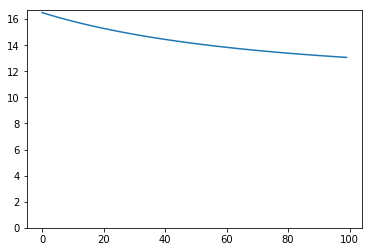

In [40]:
fig, ax = plt.subplots()
plt.plot(losses)
ax.set_ylim(ymin=0)

In [41]:
# In order to have proper word2vec we need to sum variables with biases
vectors = sess.run(W1 + b1)

In [42]:
vectors[0]

array([ 1.6619563 , -1.0549307 ,  2.6038985 ,  0.12125186,  0.83705056,
       -1.5220432 ,  1.3179718 , -0.79900974,  0.38480353, -0.14116944],
      dtype=float32)

In [43]:
from sklearn.manifold import TSNE

In [44]:
# Let's do PCA on vactors so it will be possible to visualize them
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

In [45]:
vectors[0]

array([3.1747959, 7.4189672], dtype=float32)

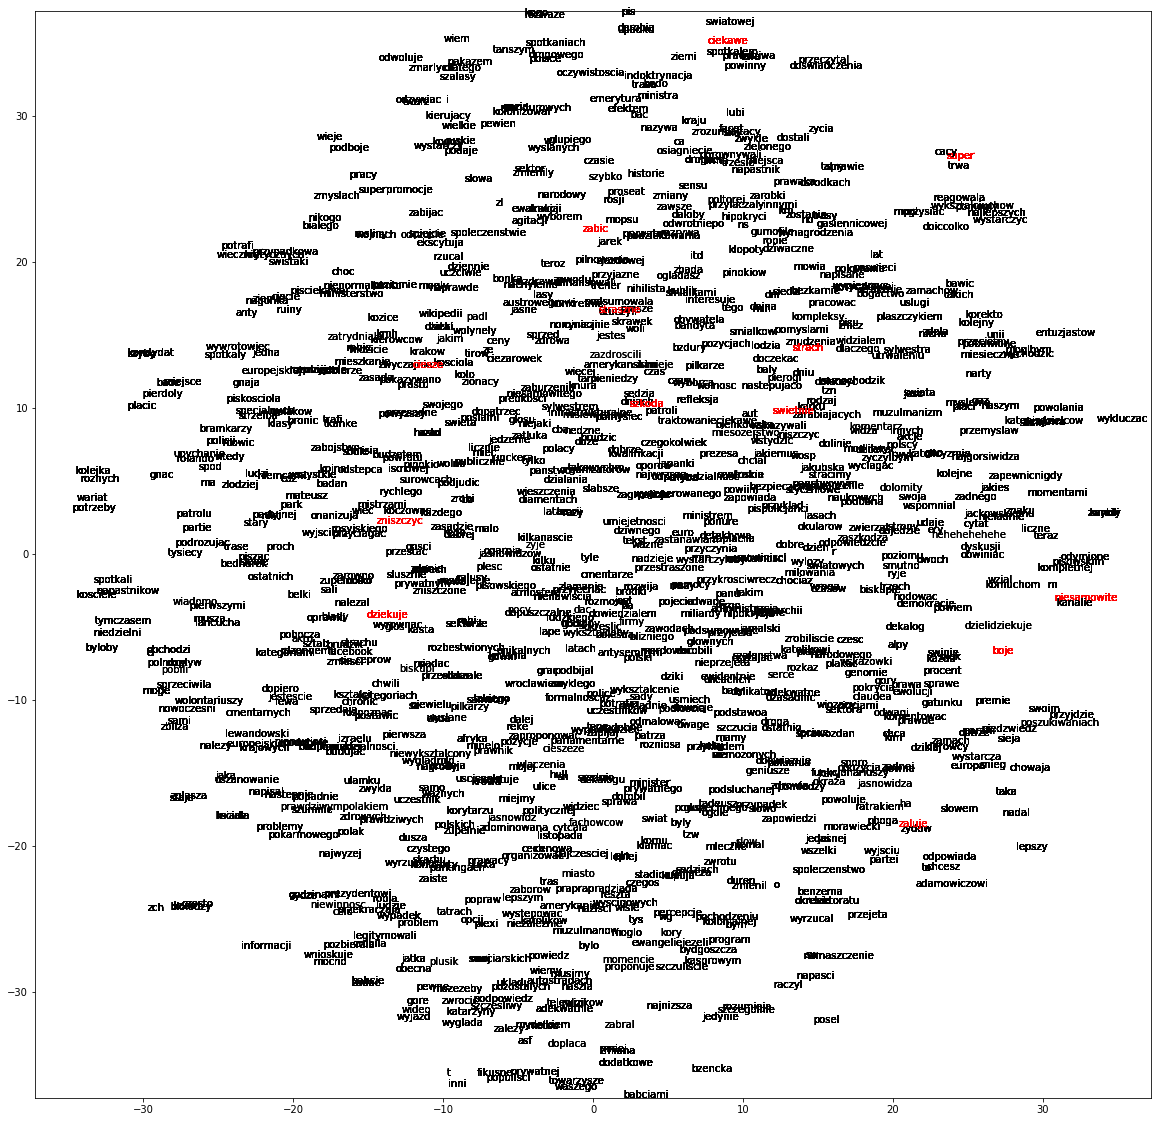

In [46]:
a = max(vectors.T.max(), -vectors.T.min())
fig, ax = plt.subplots(figsize = (20,20))
ax.axis([-a, a, -a, a])
for word in words:
    if word in all_flag_words:
        ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ), color = 'red')
    else:
        ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()

It also won't gave us anything usefull. Words around flag ones are not related, even the words like 'happy'(ciesze) and 'kill'(zabic) are close to each other.